# PyTorch Tutorial - Grad-CAM

Jinhyeok Jeong 
2024-07-09

You may want to install opencv package for running this demo:
https://opencv.org/get-started/
``` 
pip3 install opencv-python
```

In [1]:
import torch
from torch import nn 

import torchvision
from torchvision import datasets 
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np 
import matplotlib.pyplot as plt 

from torchinfo import summary

# Visual Explanation of CNNs

Assuming that you trained a (or got a pre-treind) convolutional neural network model for image classification task. 

To understand how CNN model make a prediction for a given image, knowing which region of an image contributed more to a decision might be helpful.

Several methods have been developed to visualize where CNN model is looking for when making a classification.
Here, we will learn how to implement and use the Grad-CAM, which is one of the widely used methods for this purpose.

![img_gradcam_example.png](img_gradcam_example.png)

Grad-CAM use the feature maps that are created from the last (or at least very late) convolutional layers to determine which features of an image contributed to a decision. 

It weights the feature maps with the gradients computed during back-propagation from a specific unit in the classification layer, resulting in a heatmap that hightlights the important region in the image. This heatmap indicates which parts of the image had the most influence on the network's decision, providing a visual explanation for the model's pediction.

![img_gradcam_diagram.PNG](img_gradcam_diagram.PNG)

These methods are useful to understand why our model makes a certain prediction (regardless of whether it's correct or not).

Sometimes, a heatmap generated from Grad-CAM or similar methods is considered as a saliency map or attention map of a model.

For more detail about Grad-CAM, I would recommend reading the original paper: https://arxiv.org/pdf/1610.02391

If you are less interested in understanding how does it work and just want to use it, there are multiple pacakages that you can use. Here is an example: 
- pytorch_grad_cam package: https://github.com/jacobgil/pytorch-grad-cam/


# Example - using Grad-CAM to understand pre-trained CNN

We will use VGG19 model pre-trained for Imagenet

In [2]:
from torchvision.models import vgg19

model = vgg19(weights='DEFAULT') # use weights pretrained for ImageNet

summary(model)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─Conv2d: 2-17                      590,080
│    └─ReLU: 2-18                        --
│    └─MaxPool2d: 2-19             

Prepare an image for grad-CAM

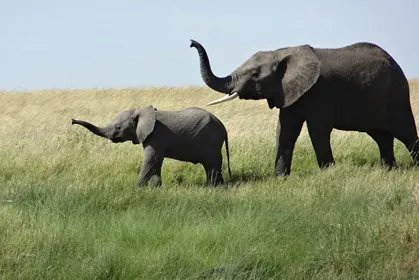

In [3]:
from torch.utils import data
from PIL import Image

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# load a single image
img = Image.open('elephant.jpeg')

# show an image
display(img)

# preprocessing
img = transform(img).reshape((1,3,224,224)) 

Prepare ImageNet labels

In [4]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    labels = eval(f.read())

labels

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In order to compute grad-CAM, we need to get the activation of the last convolutional layer given an input image. In addition, we need the gradient of class layer with respect to the activation maps.

In [5]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()

        # get the pretrained VGG19 network
        self.vgg = vgg19(weights='DEFAULT')

        # take the early layers up to the last conv layer of interest
        self.features_conv = self.vgg.features[:36] # before the last MaxPool2d in feature part

        # the remaining parts of the pretrained network
        self.max_pool = self.vgg.features[36]
        self.avg_pool = self.vgg.avgpool
        self.classifier = self.vgg.classifier

        # placeholder for gradient
        self.gradients = None

    # function used for hook
    def activation_hook(self, grad):
        self.gradients = grad

    def forward(self, x):

        x = self.features_conv(x)

        # register hook! (it will record the gradient of output wrt activations)
        h = x.register_hook(self.activation_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = self.avg_pool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)

        return x

    # function for extracting gradient
    def get_activations_gradient(self):
        return self.gradients

    # function for extracting activations
    def get_activations(self, x):
        return self.features_conv(x)

feed an image and test the prediction of a model

In [7]:
model = VGG()
model.eval()

y = model(img) # output: [1, 1000] tensor

pred = y.argmax(dim=1)

pred_label = labels[ pred.item() ]

print(pred)
print(pred_label)

tensor([386])
African elephant, Loxodonta africana


After doing a back-prop for the relevant output node (386 = African elephant), we can get the its gradient wrt activations and the activations themselves

In [8]:
y[:,pred.item()].backward() # back-prop for computing gradients (registered hook will record gradient)

# pull the gradients from the model
gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0,2,3]) # average the gradients across the channels

# get the activations of the last conv layer
activations = model.get_activations(img).detach()

print(gradients.shape) # (batchsize, n_filters, h of filter, 2 of filter)
print(pooled_gradients.shape)
print(activations.shape)

torch.Size([1, 512, 14, 14])
torch.Size([512])
torch.Size([1, 512, 14, 14])


Grad-CAM is computed by weighting activations of feature maps with corresponding gradients. 
The average of (gradient) weighted feature maps would be grad-CAM.

(14, 14)


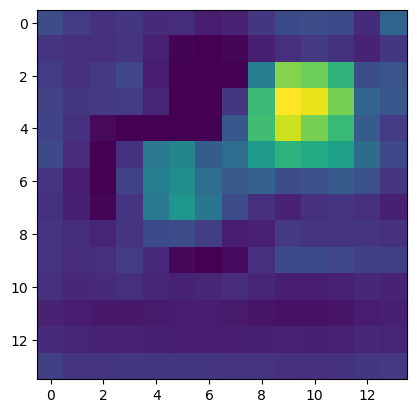

In [9]:
# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = np.maximum(heatmap,0)
# normalization
heatmap /= torch.max(heatmap)
# make it as a ndarray
heatmap = heatmap.numpy()

print(heatmap.shape)

plt.imshow(heatmap)

Using OpenCV functions to superimpose original image and grad-CAM heatmap.

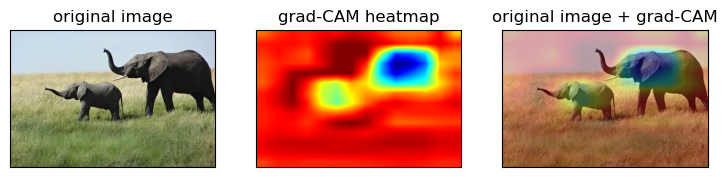

In [10]:
import cv2 

img = cv2.imread('elephant.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img 

# cv2.imwrite('./map.jpg', superimposed_img)

fig, axs = plt.subplots(1,3,figsize=(9,3))
axs[0].imshow(img); axs[0].set_title('original image')
axs[1].imshow(heatmap); axs[1].set_title('grad-CAM heatmap')
axs[2].imshow(superimposed_img / np.max(superimposed_img)); axs[2].set_title('original image + grad-CAM')

for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Let's try another example, which has multiple objects with different categories

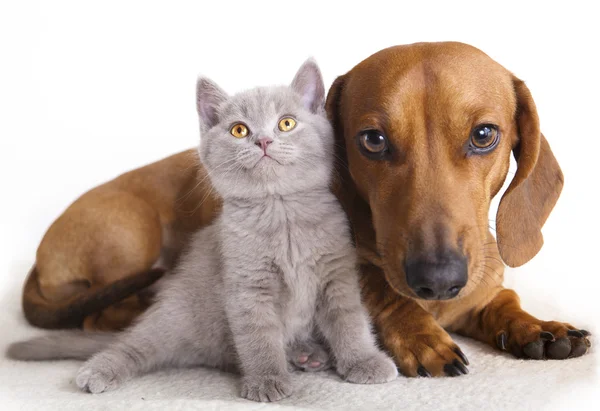

tensor([168])
redbone


In [26]:
catdog = Image.open('catdog.jpg')
display(catdog)

catdog = transform(catdog).reshape((1,3,224,224))

model.eval()

y2 = model(catdog) # output: [1, 1000] tensor

pred2 = y2.argmax(dim=1)

pred2_label = labels[ pred2.item() ]

print(pred2)
print(pred2_label)

(14, 14)


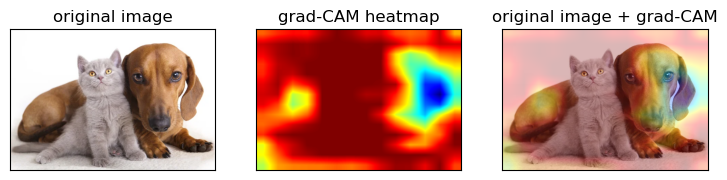

In [27]:
y2[:,pred2.item()].backward() # back-prop for computing gradients (registered hook will record gradient)

# pull the gradients from the model
gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0,2,3]) # average the gradients across the channels

# get the activations of the last conv layer
activations = model.get_activations(catdog).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = np.maximum(heatmap,0)
# normalization
heatmap /= torch.max(heatmap)
# make it as a ndarray
heatmap = heatmap.numpy()

print(heatmap.shape)

img = cv2.imread('catdog.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img 

# cv2.imwrite('./map.jpg', superimposed_img)

fig, axs = plt.subplots(1,3,figsize=(9,3))
axs[0].imshow(img); axs[0].set_title('original image')
axs[1].imshow(heatmap); axs[1].set_title('grad-CAM heatmap')
axs[2].imshow(superimposed_img / np.max(superimposed_img)); axs[2].set_title('original image + grad-CAM')

for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

what if I use output unit corresponding to different class label?

I will use the unit corresponding to a cat to see whether grad-CAM can capture a cat in the image.

Egyptian cat


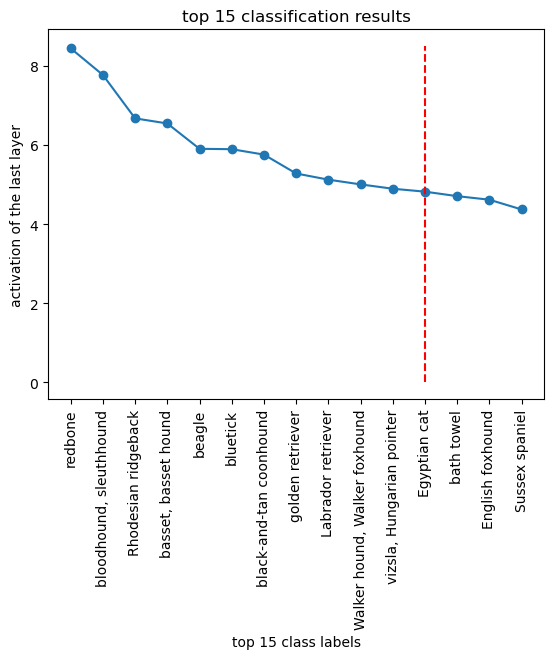

In [13]:
print(labels[285])

plt.plot(range(15),y2.topk(15).values.detach().numpy().squeeze(),'o-')
plt.xticks(range(15),[labels[x.item()] for x in y2.topk(15).indices.detach().numpy().squeeze()],rotation=90)
plt.title('top 15 classification results')
plt.plot([11,11],[0,8.5],'r--')
plt.xlabel('top 15 class labels')
plt.ylabel('activation of the last layer')
plt.show()

(14, 14)


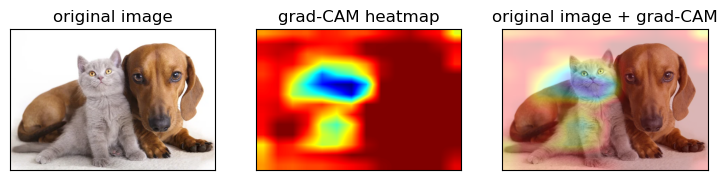

In [19]:
y2 = model(catdog) # output: [1, 1000] tensor

pred2 = y2.argmax(dim=1)

pred2_label = labels[ pred2.item() ]

y2[:,285].backward() # back-prop for computing gradients (registered hook will record gradient)

# pull the gradients from the model
gradients = model.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0,2,3]) # average the gradients across the channels

# get the activations of the last conv layer
activations = model.get_activations(catdog).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = np.maximum(heatmap,0)
# normalization
heatmap /= torch.max(heatmap)
# make it as a ndarray
heatmap = heatmap.numpy()

print(heatmap.shape)

img = cv2.imread('catdog.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img 

# cv2.imwrite('./map.jpg', superimposed_img)

fig, axs = plt.subplots(1,3,figsize=(9,3))
axs[0].imshow(img); axs[0].set_title('original image')
axs[1].imshow(heatmap); axs[1].set_title('grad-CAM heatmap')
axs[2].imshow(superimposed_img / np.max(superimposed_img)); axs[2].set_title('original image + grad-CAM')

for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])